# **1) Initiall Instructions**

In [3]:
!pip install -q catboost
!pip install -q optuna

In [4]:
import pandas as pd
import scipy
from scipy.stats import chi2_contingency, spearmanr
import numpy as np
import catboost
from catboost import CatBoostClassifier
import os
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from joblib import dump

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, classification_report, confusion_matrix, f1_score

print("Pandas version:", pd.__version__)
print("CatBoost version:", catboost.__version__)

Pandas version: 2.2.2
CatBoost version: 1.2.8


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
os.chdir('/content/drive/MyDrive/tarczyca')

# **2) Data Preparation, Visualization and Analysis**

In [7]:
data = pd.read_csv(r'/content/drive/MyDrive/tarczyca/thyroid_cancer_risk_data.csv')
df = pd.DataFrame(data)

df.head()

,Patient_ID,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,1,66,Male,Russia,Caucasian,No,Yes,No,No,No,No,9.37,1.67,6.16,1.08,Low,Benign
1,2,29,Male,Germany,Hispanic,No,Yes,No,No,No,No,1.83,1.73,10.54,4.05,Low,Benign
2,3,86,Male,Nigeria,Caucasian,No,No,No,No,No,No,6.26,2.59,10.57,4.61,Low,Benign
3,4,75,Female,India,Asian,No,No,No,No,No,No,4.10,2.62,11.04,2.46,Medium,Benign
4,5,35,Female,Germany,African,Yes,Yes,No,No,No,No,9.10,2.11,10.71,2.11,High,Benign


In [8]:
ser = df.isna().sum()
out_ser = ser.sum()

if out_ser == 0:
  print('No missing values within data')
else:
  print('Missing values existed')

No missing values within data


In [9]:
#I have changed the unit from µg/dl to ng/dl because T3 is expressed in ng/dl
df['T4_Level'] = df['T4_Level'] * 1000

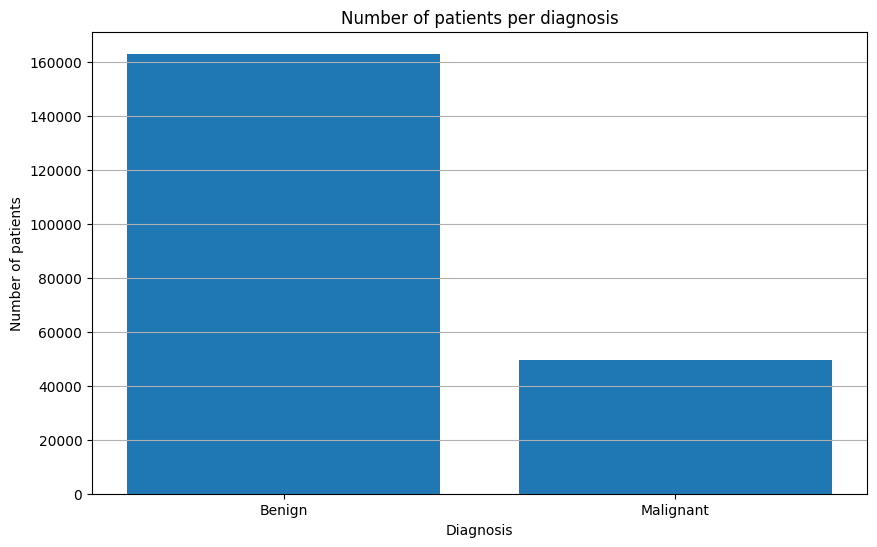

In [10]:
#Highly unbalanced classes

classes = df['Diagnosis'].value_counts()

fig = plt.figure(figsize=(10,6))
plt.bar(classes.index, classes)
plt.ylabel('Number of patients')
plt.xlabel('Diagnosis')
plt.grid(axis='y')
plt.title('Number of patients per diagnosis')
plt.show()

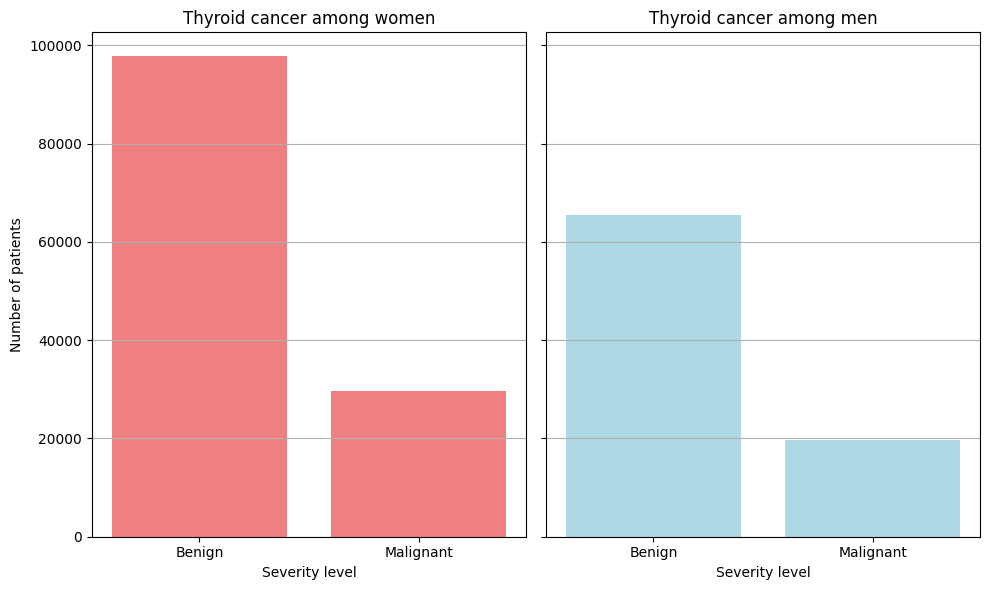

In [11]:
df = df.drop('Patient_ID', axis=1)

women_benign = df[(df['Gender'] == 'Female') & (df['Diagnosis'] == 'Benign')]
women_malignant = df[(df['Gender'] == 'Female') & (df['Diagnosis'] == 'Malignant')]

men_benign = df[(df['Gender'] == 'Male') & (df['Diagnosis'] == 'Benign')]
men_malignant = df[(df['Gender'] == 'Male') & (df['Diagnosis'] == 'Malignant')]

men_benign_count = men_benign.shape[0]
men_malignant_count = men_malignant.shape[0]
women_benign_count = women_benign.shape[0]
women_malignant_count = women_malignant.shape[0]


fig,ax = plt.subplots(1,2,sharey=True, figsize=(10,6))

ax[0].bar(['Benign', 'Malignant'], [women_benign_count, women_malignant_count], color='lightcoral')
ax[0].set_ylabel('Number of patients')
ax[0].set_xlabel('Severity level')
ax[0].grid(axis='y')
ax[0].set_title('Thyroid cancer among women')

ax[1].bar(['Benign', 'Malignant'], [men_benign_count, men_malignant_count], color='lightblue')
ax[1].set_xlabel('Severity level')
ax[1].grid(axis='y')
ax[1].set_title('Thyroid cancer among men')


plt.tight_layout()
plt.show()

In [12]:
df['Diagnosis'] = df['Diagnosis'].map({'Benign': 0, 'Malignant': 1})

cat_list = [col for col in df.columns if df[col].dtype == 'object' and col != 'Diagnosis']
num_list = [col for col in df.columns if df[col].dtype == 'int64' or df[col].dtype == 'float64']

In [13]:
#H0 - variables are independent
#H1 - variables are dependent

for col in cat_list:
  table = pd.crosstab(df[col], df['Diagnosis'])

  chi2, p, dof, expected = chi2_contingency(table)

  print()
  print(f'Test for column: {col}')
  print("Chi²:", chi2)
  print("p-value:", p)

  if p < 0.05:
      print(f"H0 rejected – significant relationship between {col} and Diagnosis.")
  else:
      print("H0 not rejected – variables are independent.")



Test for column: Gender
Chi²: 0.4337266136284724
p-value: 0.5101659983994197
H0 not rejected – variables are independent.

Test for column: Country
Chi²: 2757.4209100488915
p-value: 0.0
H0 rejected – significant relationship between Country and Diagnosis.

Test for column: Ethnicity
Chi²: 5146.68384108599
p-value: 0.0
H0 rejected – significant relationship between Ethnicity and Diagnosis.

Test for column: Family_History
Chi²: 4223.059165917239
p-value: 0.0
H0 rejected – significant relationship between Family_History and Diagnosis.

Test for column: Radiation_Exposure
Chi²: 1685.7536394973827
p-value: 0.0
H0 rejected – significant relationship between Radiation_Exposure and Diagnosis.

Test for column: Iodine_Deficiency
Chi²: 2085.3999378189264
p-value: 0.0
H0 rejected – significant relationship between Iodine_Deficiency and Diagnosis.

Test for column: Smoking
Chi²: 0.15284493753999137
p-value: 0.6958313253476616
H0 not rejected – variables are independent.

Test for column: Obesity

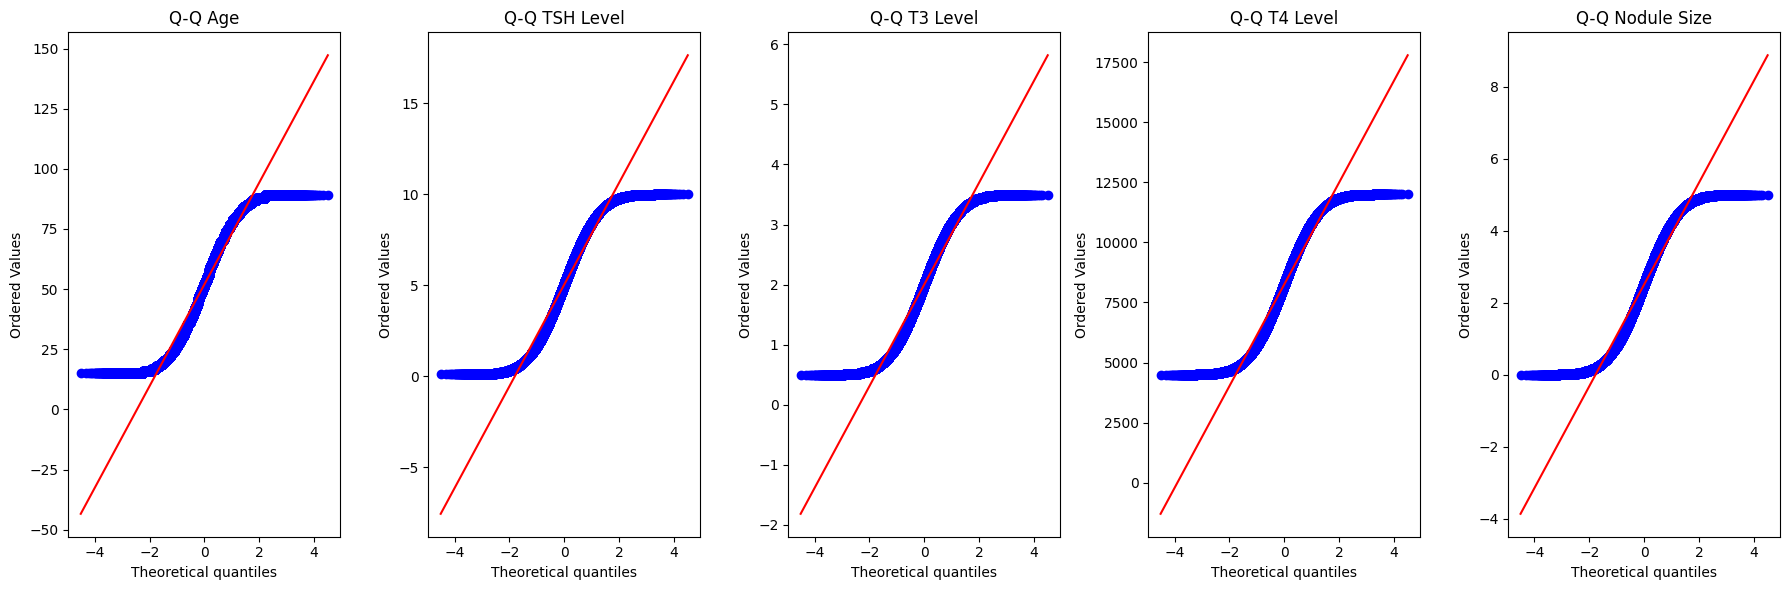

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(18, 6))

scipy.stats.probplot(df['Age'], dist='norm', plot=ax[0])
ax[0].set_title('Q-Q Age')

scipy.stats.probplot(df['TSH_Level'], dist='norm', plot=ax[1])
ax[1].set_title('Q-Q TSH Level')

scipy.stats.probplot(df['T3_Level'], dist='norm', plot=ax[2])
ax[2].set_title('Q-Q T3 Level')

scipy.stats.probplot(df['T4_Level'], dist='norm', plot=ax[3])
ax[3].set_title('Q-Q T4 Level')

scipy.stats.probplot(df['Nodule_Size'], dist='norm', plot=ax[4])
ax[4].set_title('Q-Q Nodule Size')

plt.tight_layout()
plt.show()


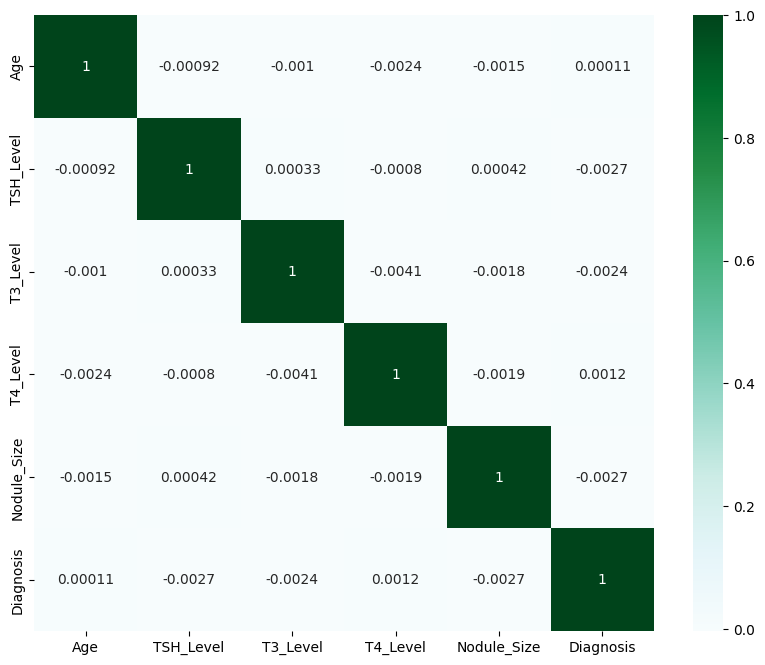

In [15]:
#QQ plots showed that none of the features were normally distributed. Hence, the 'spearman' method was used to calculate correlations.
correlation = df[num_list].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='BuGn')
plt.show()

In [16]:
#Correlation matrix shows no correlation between Diagnosis and numerical features


for col in num_list:
  if col == 'Diagnosis':
    continue

  r, p_value = spearmanr(df[col], df['Diagnosis'])

  print()
  print(f'Test for column: {col}')
  print(f"Spearman correlation: {r:.3f}")
  print(f"P-value: {p_value:.3f}")

  if p_value < 0.05:
      print("H0 rejected – correlation is statistically significant.")
  else:
      print("H0 not rejected – correlation is not statistically significant.")


Test for column: Age
Spearman correlation: 0.000
P-value: 0.958
H0 not rejected – correlation is not statistically significant.

Test for column: TSH_Level
Spearman correlation: -0.003
P-value: 0.218
H0 not rejected – correlation is not statistically significant.

Test for column: T3_Level
Spearman correlation: -0.002
P-value: 0.270
H0 not rejected – correlation is not statistically significant.

Test for column: T4_Level
Spearman correlation: 0.001
P-value: 0.575
H0 not rejected – correlation is not statistically significant.

Test for column: Nodule_Size
Spearman correlation: -0.003
P-value: 0.220
H0 not rejected – correlation is not statistically significant.


In [17]:
y = df['Diagnosis']
X = df.drop('Diagnosis', axis=1)

# **3) Training**

In [18]:
dict_of_scores = {'random_seed':[], 'acc':[], 'mcc':[], 'cr':[], 'cm':[]}

for rs in range(1, 101):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=y)


  model_catboost_before_optuna = CatBoostClassifier(auto_class_weights='Balanced', random_seed=rs, task_type='GPU')
  model_catboost_before_optuna.fit(X_train, y_train, cat_features=cat_list, verbose=False)

  y_pred = model_catboost_before_optuna.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  mcc = matthews_corrcoef(y_test, y_pred)
  cr = classification_report(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)

  dict_of_scores['random_seed'].append(rs)
  dict_of_scores['acc'].append(acc)
  dict_of_scores['mcc'].append(mcc)
  dict_of_scores['cr'].append(cr)
  dict_of_scores['cm'].append(cm)

  print(f'Model with random seed = {rs} calculated')

Model with random seed = 1 calculated
Model with random seed = 2 calculated
Model with random seed = 3 calculated
Model with random seed = 4 calculated
Model with random seed = 5 calculated
Model with random seed = 6 calculated
Model with random seed = 7 calculated
Model with random seed = 8 calculated
Model with random seed = 9 calculated
Model with random seed = 10 calculated
Model with random seed = 11 calculated
Model with random seed = 12 calculated
Model with random seed = 13 calculated
Model with random seed = 14 calculated
Model with random seed = 15 calculated
Model with random seed = 16 calculated
Model with random seed = 17 calculated
Model with random seed = 18 calculated
Model with random seed = 19 calculated
Model with random seed = 20 calculated
Model with random seed = 21 calculated
Model with random seed = 22 calculated
Model with random seed = 23 calculated
Model with random seed = 24 calculated
Model with random seed = 25 calculated
Model with random seed = 26 calcul

In [19]:
df_catboost_out = pd.DataFrame(dict_of_scores)

In [20]:
#Due to the fact that the most important thing is for sick people to be correctly diagnosed and have the opportunity to start diagnostics and therapy quickly,
#I decided to optimize the model for the highest possible number of correct predictions for class 1 (malignant) records.

max_row = df_catboost_out.loc[df_catboost_out['cm'].apply(lambda cm: cm[1][1]).idxmax()]
cm_arr = np.array(max_row['cm'])

print(f'Best random seed value: {max_row["random_seed"]}')
print(f'Test acc: {max_row["acc"]}')
print(f'Test mcc: {max_row["mcc"]}')
print()

print('Classification report:')
cr = max_row['cr']
print(cr)

Best random seed value: 77
Test acc: 0.8304849667364066
Test mcc: 0.47621049127038106

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.90     32640
           1       0.71      0.46      0.56      9899

    accuracy                           0.83     42539
   macro avg       0.78      0.70      0.73     42539
weighted avg       0.82      0.83      0.82     42539



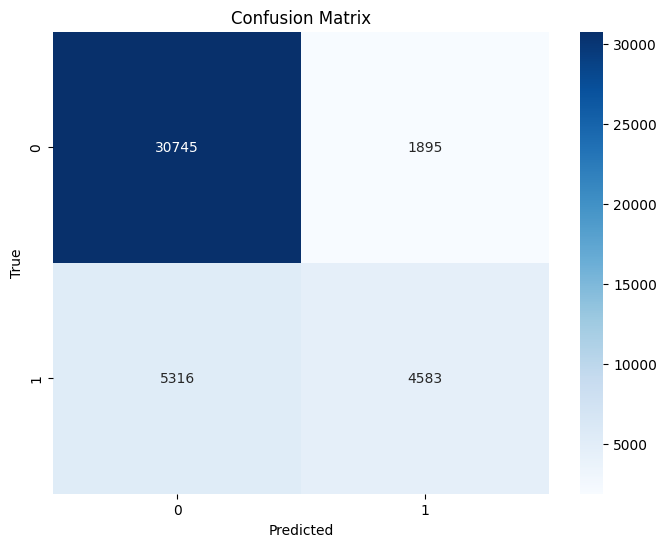

In [21]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_arr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **4) Optuna Hyperparameter Tuning**

In [22]:
#Optuna tuning with best random seed value: 77
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)

def objective(trial):
  iterations = trial.suggest_int('iterations', 100, 1000)
  depth = trial.suggest_int('depth', 4, 10)
  learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3)
  l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
  bagging_temperature = trial.suggest_float('bagging_temperature', 0, 10)
  verbose = 0

  model = CatBoostClassifier(iterations=iterations,
                             depth=depth,
                             learning_rate=learning_rate,
                             l2_leaf_reg=l2_leaf_reg,
                             bagging_temperature=bagging_temperature,
                             verbose=verbose,
                             random_seed=77,
                             auto_class_weights='Balanced',
                             task_type='GPU',
                            )

  model.fit(X_train, y_train, cat_features=cat_list)

  return  accuracy_score(y_test, model.predict(X_test))

In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-04-16 08:57:37,777] A new study created in memory with name: no-name-6fc458f0-cb5d-451a-94a5-d39df5ab0452
[I 2025-04-16 08:58:24,254] Trial 0 finished with value: 0.830343919697219 and parameters: {'iterations': 810, 'depth': 9, 'learning_rate': 0.018266910435754416, 'l2_leaf_reg': 2.0240673875859883, 'bagging_temperature': 0.912849132220197}. Best is trial 0 with value: 0.830343919697219.
[I 2025-04-16 08:58:33,627] Trial 1 finished with value: 0.8298972707397917 and parameters: {'iterations': 447, 'depth': 5, 'learning_rate': 0.19436360954034143, 'l2_leaf_reg': 1.9458778639682053, 'bagging_temperature': 9.208431047059552}. Best is trial 0 with value: 0.830343919697219.
[I 2025-04-16 08:58:46,959] Trial 2 finished with value: 0.8275699945931968 and parameters: {'iterations': 753, 'depth': 4, 'learning_rate': 0.22232446954717883, 'l2_leaf_reg': 7.300601312386564, 'bagging_temperature': 1.1172317857450165}. Best is trial 0 with value: 0.830343919697219.
[I 2025-04-16 08:59:23,09

In [24]:
best_params = study.best_params
iterations = best_params['iterations']
depth = best_params['depth']
learning_rate = best_params['learning_rate']
l2_leaf_reg = best_params['l2_leaf_reg']
bagging_temperature = best_params['bagging_temperature']

catboost_after_optuna = CatBoostClassifier(iterations=iterations,
                                          depth=depth,
                                          learning_rate=learning_rate,
                                          l2_leaf_reg=l2_leaf_reg,
                                          bagging_temperature=bagging_temperature,
                                          verbose=0,
                                          random_seed=77,
                                          auto_class_weights='Balanced',
                                          task_type='GPU'
                                          )

catboost_after_optuna.fit(X_train, y_train, cat_features=cat_list)
y_pred = catboost_after_optuna.predict(X_test)
acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f'Test acc: {acc}')
print(f'Test mcc: {mcc}')
print()

print('Classification report:')
print(cr)

Test acc: 0.8305084745762712
Test mcc: 0.4762766819783855

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.90     32640
           1       0.71      0.46      0.56      9899

    accuracy                           0.83     42539
   macro avg       0.78      0.70      0.73     42539
weighted avg       0.82      0.83      0.82     42539



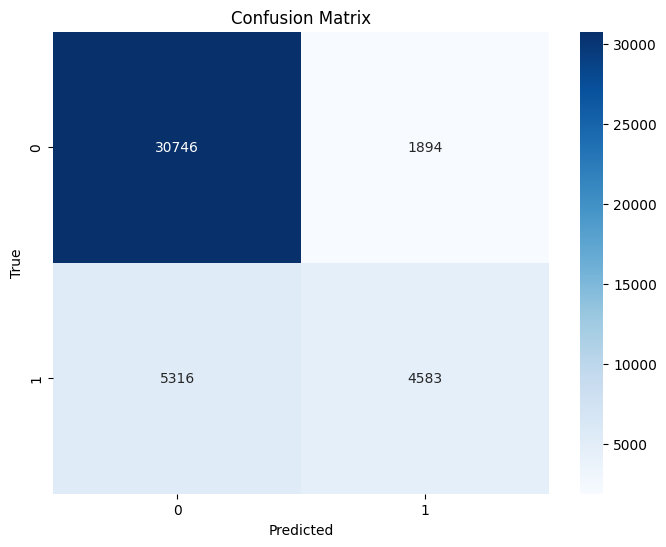

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **5) Model save**

In [26]:
# filepath = os.path.join(os.getcwd(),'model_catboost_before_optuna.joblib')
# dump(model_catboost_before_optuna, filepath)